In [1]:
!pip install qiskit qiskit-aer matplotlib numpy pylatexenc --quiet

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# For Task 4 Visualization in Colab
from IPython.display import display

# For Task 5 Noise Simulation
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import pauli_error, depolarizing_error

# =============================================================================
# 2. CORE FUNCTIONS
# =============================================================================

def inverse_qft(qc, n):
    """Apply the inverse Quantum Fourier Transform on n qubits."""
    # This is the QFT_dagger gate

    for qubit in range(n // 2):
        qc.swap(qubit, n - qubit - 1)
    for j in range(n):
        for k in range(j):
            qc.cp(-np.pi / 2 ** (j - k), k, j)
        qc.h(j)
    return qc

def qpe_circuit(num_count_qubits, theta, add_measurement=True):
    """
    Constructs the Quantum Phase Estimation (QPE) circuit.

    Args:
        num_count_qubits: number of counting qubits (n)
        theta: phase parameter (phi)
        add_measurement: (bool) If True, adds measurement gates.
                         (Used for Task 4)
    """
    n = num_count_qubits
    qc = QuantumCircuit(n + 1, n)

    # Step 1: Apply Hadamard gates on counting qubits
    qc.h(range(n))

    # Step 2: Prepare eigenstate (|1>) for the target qubit
    qc.x(n)

    # Step 3: Apply controlled unitary operations (C-U^k)
    # We use the C-P gate (Controlled-Phase) as our U = P(lambda)
    # U|1> = e^(i * 2*pi*theta) |1>
    for qubit in range(n):
        # Apply C-U^(2^qubit)
        exponent = 2 ** qubit
        qc.cp(2 * np.pi * theta * exponent, qubit, n)

    # Step 4: Apply inverse QFT to counting qubits
    inverse_qft(qc, n)

    # Step 5: (Optional) Measure counting qubits
    # This is modified for Task 4
    if add_measurement:
        qc.measure(range(n), range(n))

    return qc

def run_qpe(num_count_qubits=3, theta=0.125, show_plot=True):
    """
    Executes the QPE circuit and visualizes the phase estimation result.

    *** This function now includes Task 3 (Theoretical Output) ***
    """

    # --- Task 3: Compare with Theoretical Output ---
    # Calculate the expected binary representation
    n = num_count_qubits
    expected_decimal = int(round(theta * (2**n)))
    # Format as a binary string, padding with leading zeros
    expected_binary = format(expected_decimal, f'0{n}b')

    print(f"\n--- Running QPE: n={n}, theta={theta} ---")
    print(f"    Theoretical phase: {theta}")
    print(f"    Expected decimal output: {expected_decimal}")
    print(f"    Expected binary output:  {expected_binary}")
    # -----------------------------------------------

    simulator = AerSimulator()

    # Create circuit *with* measurement
    qc = qpe_circuit(num_count_qubits, theta, add_measurement=True)

    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit, shots=2048).result()
    counts = result.get_counts()

    print(f"    Simulation finished. Resulting counts: {counts}")

    if show_plot:
        plot_histogram(counts, title=f"QPE Result (n={n}, theta={theta})")
        plt.show()

    return counts

def run_qpe_with_noise(num_count_qubits=4, theta=0.25):
    """
    Executes the QPE circuit with a custom noise model.

    *** This function is for Task 5 (Noise Simulation) ***
    """
    print(f"\n--- Running QPE with Noise: n={num_count_qubits}, theta={theta} ---")

    # 1. Create a basic noise model
    noise_model = NoiseModel()

    # Error probabilities
    p_gate1 = 0.01  # 1% error on single-qubit 'h' gates
    p_gate2 = 0.05  # 5% error on two-qubit 'cp' gates

    # QuantumError objects
    error_gate1 = depolarizing_error(p_gate1, 1)
    error_gate2 = depolarizing_error(p_gate2, 2)

    # Add errors to the noise model
    noise_model.add_all_qubit_quantum_error(error_gate1, ["h"])
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cp"])

    print(f"    Noise Model: 1-qubit error (H): {p_gate1}, 2-qubit error (CP): {p_gate2}")

    # 2. Setup simulator with the noise model
    simulator = AerSimulator(noise_model=noise_model)

    # 3. Run the circuit
    qc = qpe_circuit(num_count_qubits, theta, add_measurement=True)
    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit, shots=2048).result()
    counts = result.get_counts()

    print(f"    Noisy simulation finished. Resulting counts: {counts}")

    return counts


# **Task 1,2,3 : Changing the phase values and Qubits**

In [3]:

# Test 1
run_qpe(num_count_qubits=4, theta=0.25)  # Expected: 0.25 * 16 = 4 -> "0100"

# Test 2
run_qpe(num_count_qubits=4, theta=0.375) # Expected: 0.375 * 16 = 6 -> "0110"

# Test 3
run_qpe(num_count_qubits=4, theta=0.5)   # Expected: 0.5 * 16 = 8 -> "1000"

# --- Bonus test for Task 2: Use n=5 for higher precision ---
print("\n--- Higher Precision Test (n=5 qubits) ---")
# 0.375 = 3/8. With n=4 we get 6/16 = 3/8 (exact).
# Let's try a value that *isn't* exact for n=4, like 1/3
theta_high_prec = 1/3
print("Running with n=4 for theta = 1/3 (approx 0.333)")
run_qpe(num_count_qubits=4, theta=theta_high_prec) # Expected: 0.333 * 16 = 5.3 -> "0101" (5)

print("\nRunning with n=5 for theta = 1/3 (approx 0.333)")
run_qpe(num_count_qubits=5, theta=theta_high_prec) # Expected: 0.333 * 32 = 10.6 -> "01011" (11)
print("Notice the output for n=5 (11/32 = 0.343) is closer to 1/3 than n=4 (5/16 = 0.3125)")




--- Running QPE: n=4, theta=0.25 ---
    Theoretical phase: 0.25
    Expected decimal output: 4
    Expected binary output:  0100
    Simulation finished. Resulting counts: {'0100': 2048}

--- Running QPE: n=4, theta=0.375 ---
    Theoretical phase: 0.375
    Expected decimal output: 6
    Expected binary output:  0110
    Simulation finished. Resulting counts: {'0110': 2048}

--- Running QPE: n=4, theta=0.5 ---
    Theoretical phase: 0.5
    Expected decimal output: 8
    Expected binary output:  1000
    Simulation finished. Resulting counts: {'1000': 2048}

--- Higher Precision Test (n=5 qubits) ---
Running with n=4 for theta = 1/3 (approx 0.333)

--- Running QPE: n=4, theta=0.3333333333333333 ---
    Theoretical phase: 0.3333333333333333
    Expected decimal output: 5
    Expected binary output:  0101
    Simulation finished. Resulting counts: {'1111': 6, '1100': 10, '0001': 10, '0100': 92, '1110': 8, '0101': 1374, '1001': 11, '1101': 11, '1000': 30, '0110': 354, '1010': 11, '0011

# **Task 4: Inverse QFT Visualization**

Drawing the QPE circuit *before* measurement...
QPE circuit for n=4, theta=0.25 (before measurement):


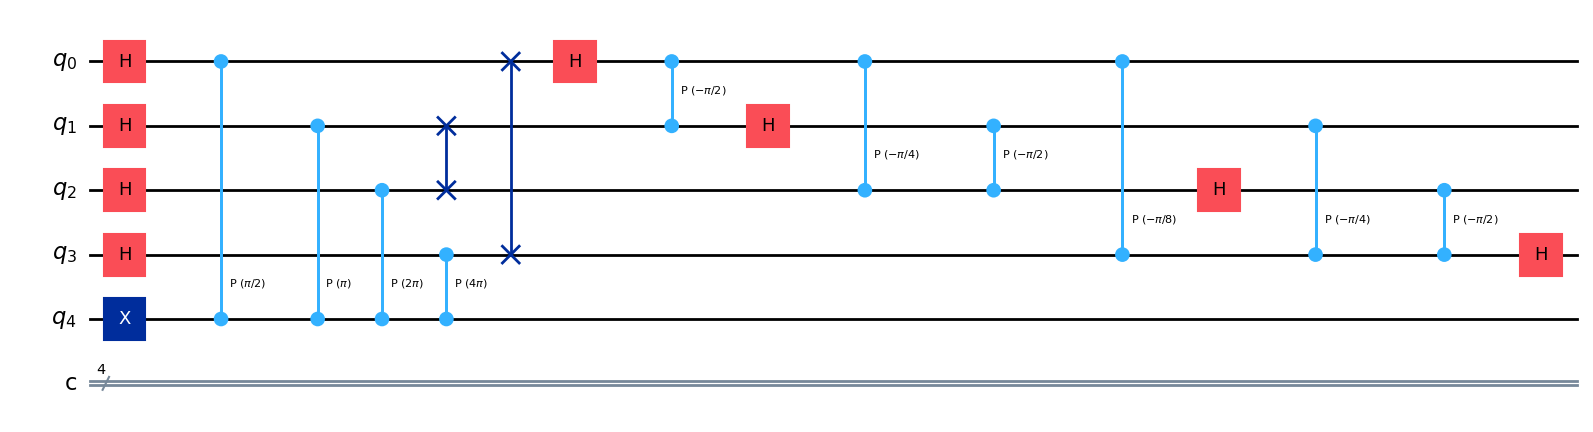

In [4]:
print("Drawing the QPE circuit *before* measurement...")

n_vis = 4  # Number of counting qubits to visualize
theta_vis = 0.25

# Create the circuit but set add_measurement=False
qc_no_measure = qpe_circuit(n_vis, theta_vis, add_measurement=False)

# Draw the circuit using 'mpl' (matplotlib)
# The 'display()' function is used to render the image in Colab
print(f"QPE circuit for n={n_vis}, theta={theta_vis} (before measurement):")

display(qc_no_measure.draw(output='mpl'))



# **Task 5: Noise Simulation**

In [6]:
n_noise = 4
theta_noise = 0.25 # Expected: "0100"

# Run 1: Ideal simulation (no noise)
counts_ideal = run_qpe(n_noise, theta_noise, show_plot=False)

# Run 2: Noisy simulation
counts_noisy = run_qpe_with_noise(n_noise, theta_noise)

# Plot a comparison
print("\n--- Comparison of Ideal vs. Noisy Results ---")
print("Ideal (blue) should have a single peak. Noisy (orange) will have other results.")
plot_histogram([counts_ideal, counts_noisy],
               legend=['Ideal', 'Noisy'],
               title=f"Ideal vs. Noisy QPE (n={n_noise}, theta={theta_noise})")
plt.show()


--- Running QPE: n=4, theta=0.25 ---
    Theoretical phase: 0.25
    Expected decimal output: 4
    Expected binary output:  0100
    Simulation finished. Resulting counts: {'0100': 2048}

--- Running QPE with Noise: n=4, theta=0.25 ---
    Noise Model: 1-qubit error (H): 0.01, 2-qubit error (CP): 0.05
    Noisy simulation finished. Resulting counts: {'1011': 2, '1010': 10, '0100': 1495, '1110': 27, '1001': 11, '0101': 58, '1100': 108, '0000': 92, '0010': 34, '0011': 20, '0111': 6, '1000': 91, '0110': 46, '1101': 27, '0001': 17, '1111': 4}

--- Comparison of Ideal vs. Noisy Results ---
Ideal (blue) should have a single peak. Noisy (orange) will have other results.
